# Useful libraries import

In [1]:
!pip install h5py
!pip install tensorflow

In [2]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
from scipy.stats.stats import mode
import seaborn as sns
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

# Classifier models
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report


# Statistic libraries
from scipy.optimize import fmin, minimize_scalar
from scipy import stats

# Importing Keras library from Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers.merge import Concatenate
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers.core import Dense
from tensorflow.python.keras.layers.pooling import GlobalAveragePooling2D
from keras.models import load_model
from os import makedirs

## Download the `app.py` file from the repo and upload it in the local environement of the notebook

In [3]:
from app import EvaluateAndReport, add_features, plot_features, to_RGB, get_distrib, DeepLearningExplore

## Data processing

In [4]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

# returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# Train/test split
df_full = df_raw.sample(frac = 0.8, random_state = 42)
df_test = df_raw.drop(df_full.index)

# Changing inc_angle from object to float64
df_full.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df_full['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df_full[df_full.inc_angle.isna()] # 133 NaN

# Adding more features to the initial dataset
def add_features(data, label) :
  data['max_b'+str(label)] = [np.max(np.array(matx)) for matx in data['band_'+str(label)]]
  data['min_b'+str(label)] = [np.min(np.array(matx)) for matx in data['band_'+str(label)]]
  data['delta_b'+str(label)] = [(np.max(np.array(matx))-np.min(np.array(matx))) for matx in data['band_'+str(label)]]
  data['median_b'+str(label)] = [np.median(np.array(matx)) for matx in data['band_'+str(label)]]
  data['mean_b'+str(label)] = [np.mean(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmax_b'+str(label)] = [np.argmax(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmin_b'+str(label)] = [np.argmin(np.array(matx)) for matx in data['band_'+str(label)]]
  data['band_'+str(label)] = [np.array(matx).reshape(75,75) for matx in data['band_'+str(label)]]
  return data
  
df_full = add_features(df_full,1)
df_full = add_features(df_full,2)

df_full['delta_max'] = df_full[['delta_b1','delta_b2']].apply(np.max,axis=1)

# Creating the two weighted bands
df_full["band_2ab"] = (2*(np.array(df_full["band_1"])-np.array(df_full["min_b1"]))+(1*np.array(df_full["band_2"]-np.array(df_full["min_b2"]))))/(3*np.array(df_full["delta_max"]))
df_full["band_a2b"] = (1*(np.array(df_full["band_1"])-np.array(df_full["min_b1"]))+(2*np.array(df_full["band_2"]-np.array(df_full["min_b2"]))))/(3*np.array(df_full["delta_max"]))

# Creating the final dataframe
df = pd.DataFrame()
df['band_1'] = df_full["band_2ab"]
df['band_2'] = df_full["band_a2b"]
df['is_iceberg'] = df_full['is_iceberg']

Mounted at /content/drive


In [5]:
# Visualising info
df.head()

,band_1,band_2,is_iceberg
530,"[[0.25427745278591074, 0.3460855742596355, 0.3...","[[0.26592376580780336, 0.3247187761665669, 0.3...",1
1140,"[[0.2707324495406702, 0.30480775175573926, 0.3...","[[0.24267567798256903, 0.30020406674866845, 0....",1
168,"[[0.38617910781788845, 0.43987529136428566, 0....","[[0.41462617396260637, 0.44598581086903305, 0....",0
135,"[[0.37422338765966945, 0.41115484466890545, 0....","[[0.39863373809855784, 0.38507994752080904, 0....",1
438,"[[0.29135156222418807, 0.22909160205562515, 0....","[[0.28848498437832754, 0.20767722540976924, 0....",0


In [6]:
df_full.head()

,id,band_1,band_2,inc_angle,is_iceberg,max_b1,min_b1,delta_b1,median_b1,mean_b1,argmax_b1,argmin_b1,max_b2,min_b2,delta_b2,median_b2,mean_b2,argmax_b2,argmin_b2,delta_max,band_2ab,band_a2b
530,f06ecb96,"[[-22.622971, -19.042347, -18.257372, -18.6973...","[[-23.36264, -22.62306, -23.962086, -24.38596,...",30.4878,1,-0.897075,-29.583092,28.686017,-18.048462,-18.112508,2667,4169,-14.703813,-31.325020,16.621207,-22.802425,-22.830266,2741,4083,28.686017,"[[0.25427745278591074, 0.3460855742596355, 0.3...","[[0.26592376580780336, 0.3247187761665669, 0.3..."
1140,974931df,"[[-27.235119, -26.907366, -24.170664, -24.1707...","[[-32.01276, -29.514042, -26.907423, -29.09036...",38.4591,1,-5.598961,-36.454388,30.855427,-26.289146,-26.294448,2888,4634,-23.071953,-38.634918,15.562965,-29.091711,-29.087352,51,1090,30.855427,"[[0.2707324495406702, 0.30480775175573926, 0.3...","[[0.24267567798256903, 0.30020406674866845, 0...."
168,d6566373,"[[-28.63821, -26.238758, -29.042387, -29.04244...","[[-25.944237, -25.659485, -28.252216, -31.4044...",39.5048,0,-8.369424,-39.927570,31.558146,-27.886208,-28.104746,3124,4853,-17.648048,-39.926807,22.278759,-28.255713,-28.530522,3198,1629,31.558146,"[[0.38617910781788845, 0.43987529136428566, 0....","[[0.41462617396260637, 0.44598581086903305, 0...."
135,6706ea46,"[[-22.52327, -20.36145, -18.631905, -19.001574...","[[-26.236002, -27.819691, -25.408276, -25.1489...",36.1091,1,-6.444110,-31.174166,24.730056,-19.936411,-20.070621,2732,2541,-18.755909,-36.697906,17.941997,-26.532661,-26.580998,2205,899,24.730056,"[[0.37422338765966945, 0.41115484466890545, 0....","[[0.39863373809855784, 0.38507994752080904, 0...."
438,b792a605,"[[-19.505417, -21.23266, -28.363649, -29.63707...","[[-28.36356, -32.289497, -32.289543, -28.76776...",42.4126,0,8.382858,-31.131157,39.514015,-20.250298,-19.967787,3187,258,-2.915977,-39.649490,36.733513,-27.980453,-27.961630,3187,2931,39.514015,"[[0.29135156222418807, 0.22909160205562515, 0....","[[0.28848498437832754, 0.20767722540976924, 0...."


## Train/test split for the whole project as we don't have a test dataset


In [17]:
# Train/test split for the whole project as we don't have a test dataset
df_train = df.sample(frac = 0.75, random_state = 42)
df_test = df.drop(df_train.index)

Train data pre-processing to match TF inputs types

In [18]:
X_b1=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df_train["band_1"]]
    )

X_b2=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df_train["band_2"]]
    )

train_cnn = np.concatenate([X_b1[:, :, :, np.newaxis], X_b2[:, :, :, np.newaxis]], axis=-1)
target_cnn=df_train['is_iceberg']

Test data pre-processing to match TF inputs types

In [19]:
X_b1_test=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df_test["band_1"]]
    )

X_b2_test=np.array(
    [np.array(band).astype(np.float64).reshape(75, 75) for band in df_test["band_2"]]
    )

test_cnn = np.concatenate([X_b1_test[:, :, :, np.newaxis], X_b2_test[:, :, :, np.newaxis]], axis=-1)
test_target_cnn=df_test['is_iceberg']

In [20]:
test_cnn

array([[[[0.27073245, 0.24267568],
         [0.30480775, 0.30020407],
         [0.3920968 , 0.38608782],
         ...,
         [0.34541386, 0.35186225],
         [0.33246418, 0.34538652],
         [0.34969801, 0.34226639]],

        [[0.30296848, 0.27640964],
         [0.31620919, 0.31277118],
         [0.35808621, 0.33370969],
         ...,
         [0.35901839, 0.32003626],
         [0.42150321, 0.3899051 ],
         [0.42150321, 0.3899051 ]],

        [[0.37590463, 0.36141454],
         [0.39550934, 0.3929129 ],
         [0.26658368, 0.2945053 ],
         ...,
         [0.33062714, 0.31306024],
         [0.3777305 , 0.32178135],
         [0.42491393, 0.36706905]],

        ...,

        [[0.45385983, 0.35986415],
         [0.31567949, 0.27419493],
         [0.32077152, 0.29331818],
         ...,
         [0.36319502, 0.33617508],
         [0.38296604, 0.34605968],
         [0.39932453, 0.31596296]],

        [[0.43872292, 0.45746627],
         [0.37261231, 0.37099636],
         [0.

In [21]:
test_target_cnn

1140    1
483     1
1573    0
914     1
30      0
       ..
1565    0
606     1
1340    1
1320    0
546     1
Name: is_iceberg, Length: 321, dtype: int64

## Create training and validation datasets

In [22]:
from sklearn.model_selection import train_test_split

X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn = train_test_split(train_cnn, target_cnn, random_state=42, train_size=0.7)

# Testing different models

## Modèle 2C3D

In [23]:
covnet_2C3D = DeepLearningExplore(df, X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn, batch_s = 20)
model_2C3D = covnet_2C3D.create_model(1, 2, drop_cv2D=True, normalization= True)

### Fitting the unique model and getting the best weights

Epoch 1/120
34/34 [==============================] - ETA: 0s - loss: 0.7620 - binary_accuracy: 0.5632
Epoch 00001: val_binary_accuracy improved from -inf to 0.44291, saving model to best_model_model_2C3D_.h5
34/34 [==============================] - 12s 37ms/step - loss: 0.7620 - binary_accuracy: 0.5632 - val_loss: 0.6959 - val_binary_accuracy: 0.4429
Epoch 2/120
32/34 [===========================>..] - ETA: 0s - loss: 0.6543 - binary_accuracy: 0.6422
Epoch 00002: val_binary_accuracy improved from 0.44291 to 0.47059, saving model to best_model_model_2C3D_.h5
34/34 [==============================] - 1s 24ms/step - loss: 0.6530 - binary_accuracy: 0.6419 - val_loss: 0.7222 - val_binary_accuracy: 0.4706
Epoch 3/120
31/34 [==========================>...] - ETA: 0s - loss: 0.6353 - binary_accuracy: 0.6210
Epoch 00003: val_binary_accuracy did not improve from 0.47059
34/34 [==============================] - 1s 19ms/step - loss: 0.6252 - binary_accuracy: 0.6300 - val_loss: 0.7925 - val_binary_a

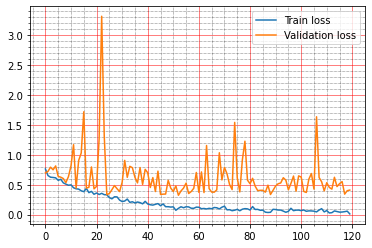

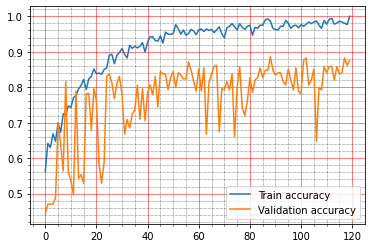

In [24]:
covnet_2C3D.get_best_trained(model_2C3D, 120, name="model_2C3D", verbose = True)

Summary of the model

In [25]:
model_2C3D.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 75, 75, 2)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 75, 75, 2)         0         
                                                                 
 conv2d (Conv2D)             (None, 75, 75, 32)        1632      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 37, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                    

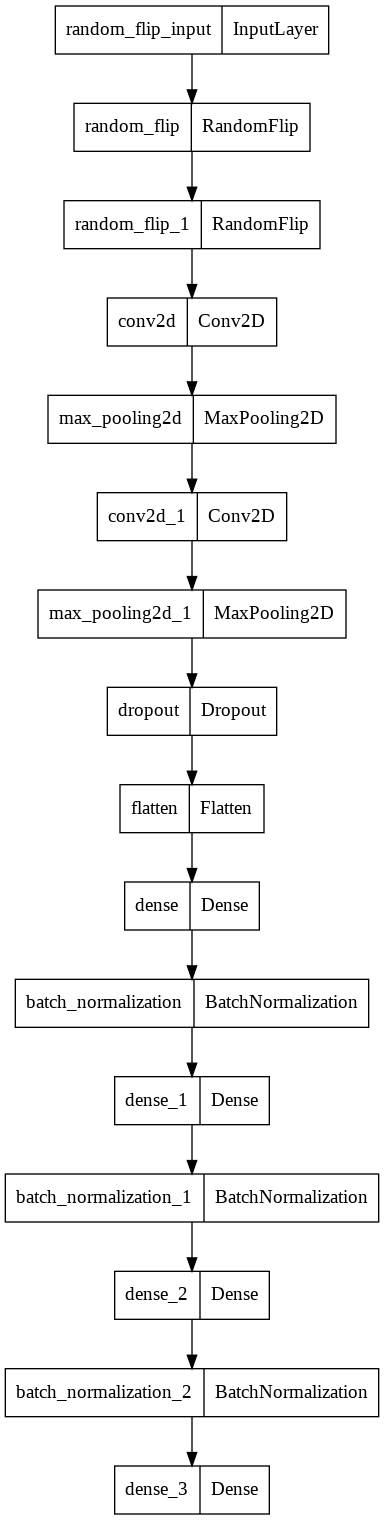

In [26]:
tf.keras.utils.plot_model(model_2C3D)

Getting the results on the final test dataset

In [27]:
covnet_2C3D.best_model.evaluate(x=test_cnn, y=test_target_cnn, return_dict=True)

11/11 [==============================] - 0s 14ms/step - loss: 0.6842 - binary_accuracy: 0.8100


{'binary_accuracy': 0.8099688291549683, 'loss': 0.684212327003479}

### Using the horizontal voting method

On the validation dataset

>>>>>>>>>>> fit no : 0 done
>>>>>>>>>>> fit no : 1 done
>>>>>>>>>>> fit no : 2 done
>>>>>>>>>>> fit no : 3 done
>>>>>>>>>>> fit no : 4 done
>>>>>>>>>>> fit no : 5 done
>>>>>>>>>>> fit no : 6 done
>>>>>>>>>>> fit no : 7 done
>>>>>>>>>>> fit no : 8 done
>>>>>>>>>>> fit no : 9 done
>>>>>>>>>>> fit no : 10 done
>>>>>>>>>>> fit no : 11 done
>>>>>>>>>>> fit no : 12 done
>>>>>>>>>>> fit no : 13 done
>>>>>>>>>>> fit no : 14 done
>>>>>>>>>>> fit no : 15 done
>>>>>>>>>>> fit no : 16 done
>>>>>>>>>>> fit no : 17 done
>>>>>>>>>>> fit no : 18 done
>>>>>>>>>>> fit no : 19 done
>>>>>>>>>>> fit no : 20 done
>>>>>>>>>>> fit no : 21 done
>>>>>>>>>>> fit no : 22 done
>>>>>>>>>>> fit no : 23 done
>>>>>>>>>>> fit no : 24 done
>>>>>>>>>>> fit no : 25 done
>>>>>>>>>>> fit no : 26 done
>>>>>>>>>>> fit no : 27 done
>>>>>>>>>>> fit no : 28 done
>>>>>>>>>>> fit no : 29 done
>>>>>>>>>>> fit no : 30 done
>>>>>>>>>>> fit no : 31 done
>>>>>>>>>>> fit no : 32 done
>>>>>>>>>>> fit no : 33 done
>>>>>>>>>>> fit no : 34 

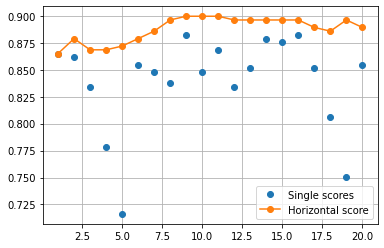

In [28]:
covnet_2C3D.horizontal_validate(n_epoch=120, n_save_after=100, threshold =0.45)

On the test dataset

>>>>>>> loaded models/model_100.h5
>>>>>>> loaded models/model_101.h5
>>>>>>> loaded models/model_102.h5
>>>>>>> loaded models/model_103.h5
>>>>>>> loaded models/model_104.h5
>>>>>>> loaded models/model_105.h5
>>>>>>> loaded models/model_106.h5
>>>>>>> loaded models/model_107.h5
>>>>>>> loaded models/model_108.h5
>>>>>>> loaded models/model_109.h5
>>>>>>> loaded models/model_110.h5
>>>>>>> loaded models/model_111.h5
>>>>>>> loaded models/model_112.h5
>>>>>>> loaded models/model_113.h5
>>>>>>> loaded models/model_114.h5
>>>>>>> loaded models/model_115.h5
>>>>>>> loaded models/model_116.h5
>>>>>>> loaded models/model_117.h5
>>>>>>> loaded models/model_118.h5
>>>>>>> loaded models/model_119.h5
Precision ensemble: 0.889831
Recall ensemble : 0.660377
F1 score ensemble: 0.758123
> 1: single=0.785, ensemble=0.791
Precision ensemble: 0.844595
Recall ensemble : 0.786164
F1 score ensemble: 0.814332
> 2: single=0.819, ensemble=0.822
Precision ensemble: 0.817073
Recall ensemble : 0.842767
F1 score

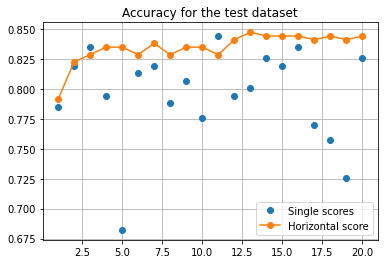

In [29]:
covnet_2C3D.horizontal_evaluate(test_cnn, test_target_cnn, n_epoch=120, n_save_after=100, threshold =0.45)

## Modèle 3C4D

Epoch 1/130
34/34 [==============================] - ETA: 0s - loss: 0.7552 - binary_accuracy: 0.5765
Epoch 00001: val_binary_accuracy improved from -inf to 0.47059, saving model to best_model_model_3C4D_.h5
34/34 [==============================] - 4s 39ms/step - loss: 0.7552 - binary_accuracy: 0.5765 - val_loss: 0.7142 - val_binary_accuracy: 0.4706
Epoch 2/130
34/34 [==============================] - ETA: 0s - loss: 0.7132 - binary_accuracy: 0.6122
Epoch 00002: val_binary_accuracy did not improve from 0.47059
34/34 [==============================] - 1s 23ms/step - loss: 0.7132 - binary_accuracy: 0.6122 - val_loss: 0.7422 - val_binary_accuracy: 0.4706
Epoch 3/130
34/34 [==============================] - ETA: 0s - loss: 0.6976 - binary_accuracy: 0.6092
Epoch 00003: val_binary_accuracy did not improve from 0.47059
34/34 [==============================] - 1s 25ms/step - loss: 0.6976 - binary_accuracy: 0.6092 - val_loss: 0.7578 - val_binary_accuracy: 0.4706
Epoch 4/130
34/34 [=============

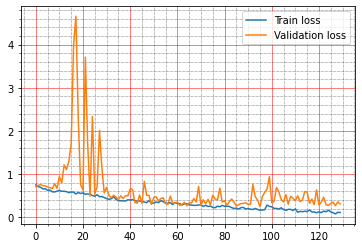

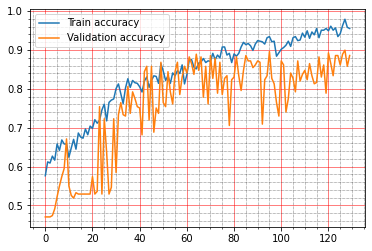

In [34]:
covnet_3C4D = DeepLearningExplore(df, X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn, batch_s = 20)
model_3C4D = covnet_3C4D.create_model(2, 3, drop_cv2D= True, normalization = True)
covnet_3C4D.get_best_trained(model_3C4D, 130, name="model_3C4D", verbose = True)

In [36]:
model_3C4D.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_6 (RandomFlip)  (None, 75, 75, 2)         0         
                                                                 
 random_flip_7 (RandomFlip)  (None, 75, 75, 2)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 75, 75, 32)        1632      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                  

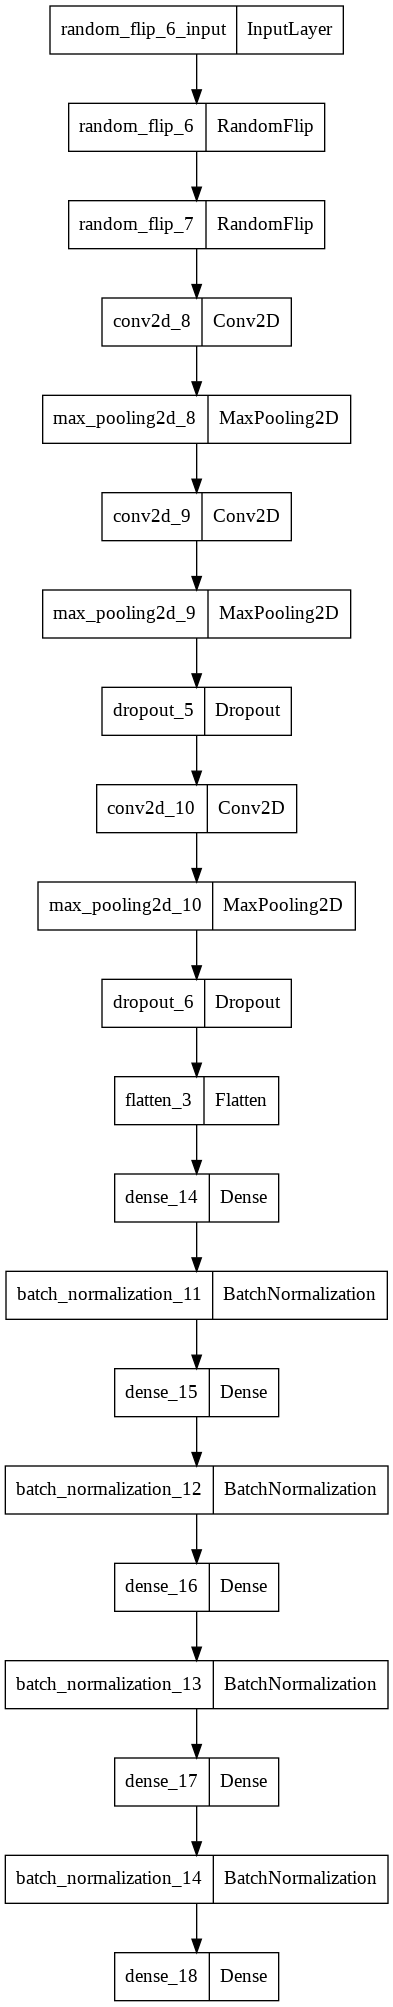

In [37]:
tf.keras.utils.plot_model(model_3C4D)

Getting the results on the final test dataset

In [38]:
covnet_3C4D.best_model.evaluate(x=test_cnn, y=test_target_cnn, return_dict=True)

11/11 [==============================] - 0s 10ms/step - loss: 0.3886 - binary_accuracy: 0.8598


{'binary_accuracy': 0.8598130941390991, 'loss': 0.38859501481056213}

### Using the horizontal vote method

On the validation dataset

>>>>>>>>>>> fit no : 0 done
>>>>>>>>>>> fit no : 1 done
>>>>>>>>>>> fit no : 2 done
>>>>>>>>>>> fit no : 3 done
>>>>>>>>>>> fit no : 4 done
>>>>>>>>>>> fit no : 5 done
>>>>>>>>>>> fit no : 6 done
>>>>>>>>>>> fit no : 7 done
>>>>>>>>>>> fit no : 8 done
>>>>>>>>>>> fit no : 9 done
>>>>>>>>>>> fit no : 10 done
>>>>>>>>>>> fit no : 11 done
>>>>>>>>>>> fit no : 12 done
>>>>>>>>>>> fit no : 13 done
>>>>>>>>>>> fit no : 14 done
>>>>>>>>>>> fit no : 15 done
>>>>>>>>>>> fit no : 16 done
>>>>>>>>>>> fit no : 17 done
>>>>>>>>>>> fit no : 18 done
>>>>>>>>>>> fit no : 19 done
>>>>>>>>>>> fit no : 20 done
>>>>>>>>>>> fit no : 21 done
>>>>>>>>>>> fit no : 22 done
>>>>>>>>>>> fit no : 23 done
>>>>>>>>>>> fit no : 24 done
>>>>>>>>>>> fit no : 25 done
>>>>>>>>>>> fit no : 26 done
>>>>>>>>>>> fit no : 27 done
>>>>>>>>>>> fit no : 28 done
>>>>>>>>>>> fit no : 29 done
>>>>>>>>>>> fit no : 30 done
>>>>>>>>>>> fit no : 31 done
>>>>>>>>>>> fit no : 32 done
>>>>>>>>>>> fit no : 33 done
>>>>>>>>>>> fit no : 34 

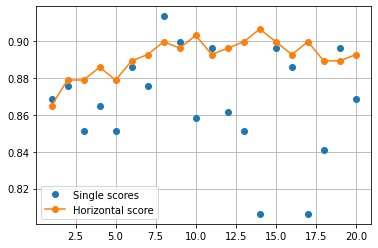

In [39]:
covnet_3C4D.horizontal_validate(n_epoch=130, n_save_after=110, threshold =0.45)

On the test dataset

>>>>>>> loaded models/model_110.h5
>>>>>>> loaded models/model_111.h5
>>>>>>> loaded models/model_112.h5
>>>>>>> loaded models/model_113.h5
>>>>>>> loaded models/model_114.h5
>>>>>>> loaded models/model_115.h5
>>>>>>> loaded models/model_116.h5
>>>>>>> loaded models/model_117.h5
>>>>>>> loaded models/model_118.h5
>>>>>>> loaded models/model_119.h5
>>>>>>> loaded models/model_120.h5
>>>>>>> loaded models/model_121.h5
>>>>>>> loaded models/model_122.h5
>>>>>>> loaded models/model_123.h5
>>>>>>> loaded models/model_124.h5
>>>>>>> loaded models/model_125.h5
>>>>>>> loaded models/model_126.h5
>>>>>>> loaded models/model_127.h5
>>>>>>> loaded models/model_128.h5
>>>>>>> loaded models/model_129.h5
Precision ensemble: 0.842105
Recall ensemble : 0.805031
F1 score ensemble: 0.823151
> 1: single=0.826, ensemble=0.829
Precision ensemble: 0.846667
Recall ensemble : 0.798742
F1 score ensemble: 0.822006
> 2: single=0.826, ensemble=0.829
Precision ensemble: 0.841060
Recall ensemble : 0.798742
F1 score

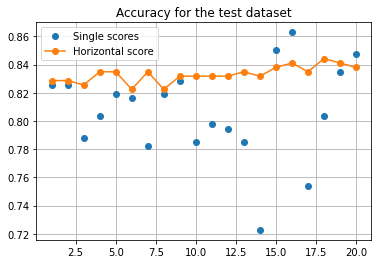

In [40]:
covnet_3C4D.horizontal_evaluate(test_cnn, test_target_cnn, n_epoch=130, n_save_after=110, threshold =0.45)

## Modèle 5C3D

Epoch 1/200
32/34 [===========================>..] - ETA: 0s - loss: 0.8847 - binary_accuracy: 0.5063
Epoch 00001: val_binary_accuracy improved from -inf to 0.52941, saving model to best_model_model_5C3D_.h5
34/34 [==============================] - 4s 40ms/step - loss: 0.8752 - binary_accuracy: 0.5097 - val_loss: 0.6908 - val_binary_accuracy: 0.5294
Epoch 2/200
33/34 [============================>.] - ETA: 0s - loss: 0.7436 - binary_accuracy: 0.5742
Epoch 00002: val_binary_accuracy did not improve from 0.52941
34/34 [==============================] - 1s 25ms/step - loss: 0.7455 - binary_accuracy: 0.5706 - val_loss: 0.6921 - val_binary_accuracy: 0.5294
Epoch 3/200
34/34 [==============================] - ETA: 0s - loss: 0.7295 - binary_accuracy: 0.5721
Epoch 00003: val_binary_accuracy did not improve from 0.52941
34/34 [==============================] - 1s 24ms/step - loss: 0.7295 - binary_accuracy: 0.5721 - val_loss: 0.6854 - val_binary_accuracy: 0.5294
Epoch 4/200
34/34 [=============

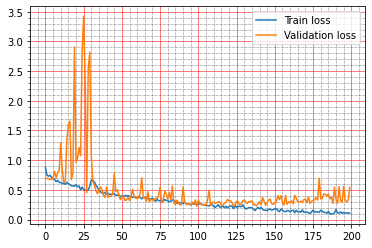

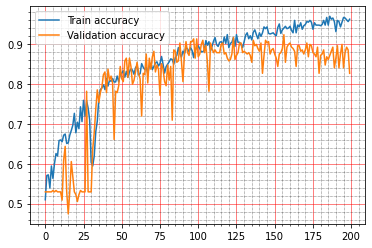

In [47]:
covnet_5C3D = DeepLearningExplore(df, X_train_cnn, X_valid_cnn, y_train_cnn, y_valid_cnn, batch_s = 20)
model_5C3D = covnet_5C3D.create_model(4, 2, drop_cv2D= True, normalization = True)
covnet_5C3D.get_best_trained(model_5C3D, 200, name="model_5C3D", verbose = True)

In [48]:
model_5C3D.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_10 (RandomFlip)  (None, 75, 75, 2)        0         
                                                                 
 random_flip_11 (RandomFlip)  (None, 75, 75, 2)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 75, 75, 32)        1632      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 18, 18, 64)       0         
 g2D)                                                 

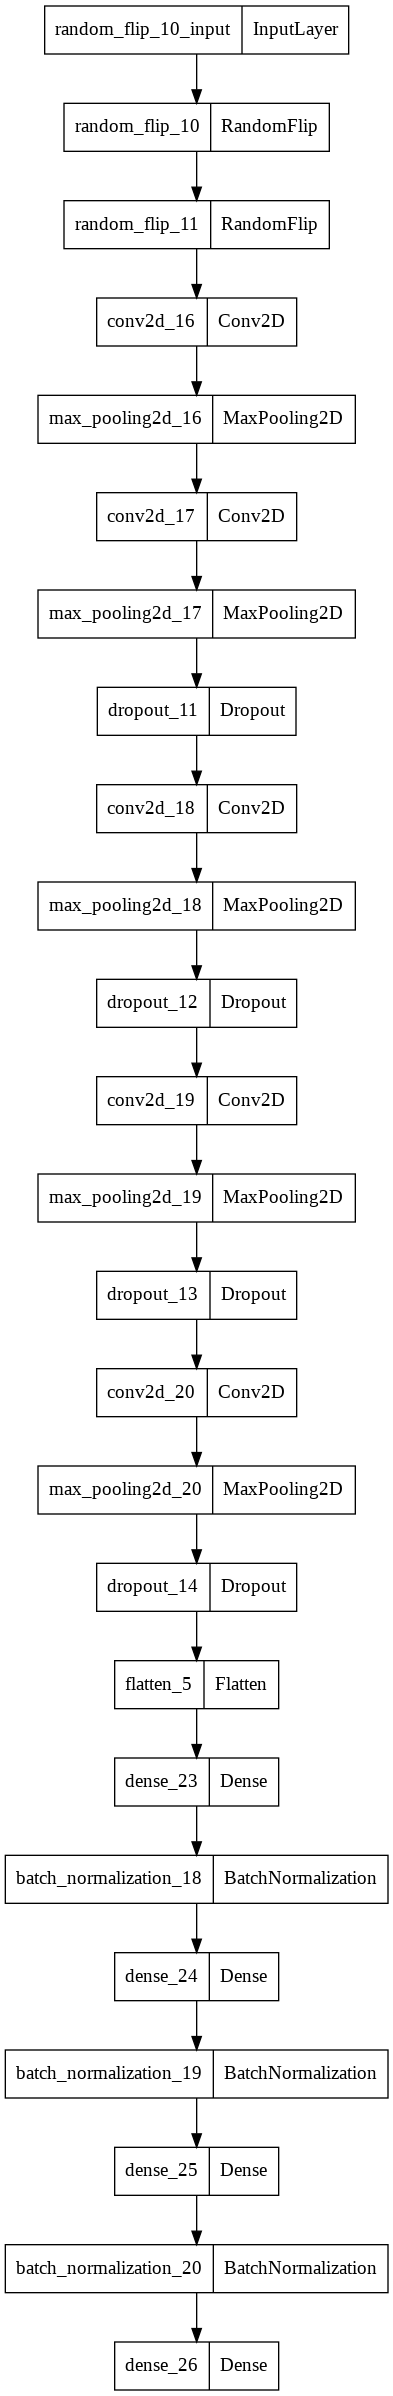

In [49]:
tf.keras.utils.plot_model(model_5C3D)

Getting the results on the final test dataset

In [50]:
covnet_5C3D.best_model.evaluate(x=test_cnn, y=test_target_cnn, return_dict=True)

11/11 [==============================] - 0s 10ms/step - loss: 0.2872 - binary_accuracy: 0.9221


{'binary_accuracy': 0.9221183657646179, 'loss': 0.2871691584587097}

### Using the horizontal vote method

On the validation dataset

>>>>>>>>>>> fit no : 0 done
>>>>>>>>>>> fit no : 1 done
>>>>>>>>>>> fit no : 2 done
>>>>>>>>>>> fit no : 3 done
>>>>>>>>>>> fit no : 4 done
>>>>>>>>>>> fit no : 5 done
>>>>>>>>>>> fit no : 6 done
>>>>>>>>>>> fit no : 7 done
>>>>>>>>>>> fit no : 8 done
>>>>>>>>>>> fit no : 9 done
>>>>>>>>>>> fit no : 10 done
>>>>>>>>>>> fit no : 11 done
>>>>>>>>>>> fit no : 12 done
>>>>>>>>>>> fit no : 13 done
>>>>>>>>>>> fit no : 14 done
>>>>>>>>>>> fit no : 15 done
>>>>>>>>>>> fit no : 16 done
>>>>>>>>>>> fit no : 17 done
>>>>>>>>>>> fit no : 18 done
>>>>>>>>>>> fit no : 19 done
>>>>>>>>>>> fit no : 20 done
>>>>>>>>>>> fit no : 21 done
>>>>>>>>>>> fit no : 22 done
>>>>>>>>>>> fit no : 23 done
>>>>>>>>>>> fit no : 24 done
>>>>>>>>>>> fit no : 25 done
>>>>>>>>>>> fit no : 26 done
>>>>>>>>>>> fit no : 27 done
>>>>>>>>>>> fit no : 28 done
>>>>>>>>>>> fit no : 29 done
>>>>>>>>>>> fit no : 30 done
>>>>>>>>>>> fit no : 31 done
>>>>>>>>>>> fit no : 32 done
>>>>>>>>>>> fit no : 33 done
>>>>>>>>>>> fit no : 34 

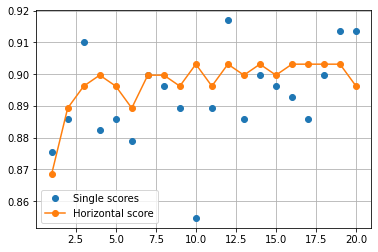

In [52]:
covnet_5C3D.horizontal_validate(n_epoch=200, n_save_after=180, threshold =0.45)

On the test dataset

>>>>>>> loaded models/model_180.h5
>>>>>>> loaded models/model_181.h5
>>>>>>> loaded models/model_182.h5
>>>>>>> loaded models/model_183.h5
>>>>>>> loaded models/model_184.h5
>>>>>>> loaded models/model_185.h5
>>>>>>> loaded models/model_186.h5
>>>>>>> loaded models/model_187.h5
>>>>>>> loaded models/model_188.h5
>>>>>>> loaded models/model_189.h5
>>>>>>> loaded models/model_190.h5
>>>>>>> loaded models/model_191.h5
>>>>>>> loaded models/model_192.h5
>>>>>>> loaded models/model_193.h5
>>>>>>> loaded models/model_194.h5
>>>>>>> loaded models/model_195.h5
>>>>>>> loaded models/model_196.h5
>>>>>>> loaded models/model_197.h5
>>>>>>> loaded models/model_198.h5
>>>>>>> loaded models/model_199.h5
Precision ensemble: 0.786885
Recall ensemble : 0.905660
F1 score ensemble: 0.842105
> 1: single=0.835, ensemble=0.832
Precision ensemble: 0.803279
Recall ensemble : 0.924528
F1 score ensemble: 0.859649
> 2: single=0.875, ensemble=0.850
Precision ensemble: 0.901316
Recall ensemble : 0.861635
F1 score

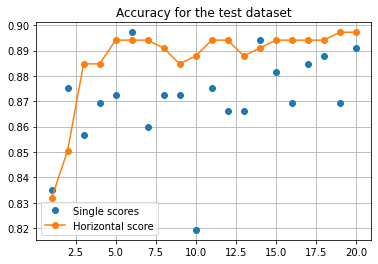

In [54]:
covnet_5C3D.horizontal_evaluate(test_cnn, test_target_cnn, n_epoch=200, n_save_after=180, threshold =0.45)

# Transfer learning

In [55]:
train_resnet50 = np.concatenate([X_b1[:, :, :, np.newaxis], X_b2[:, :, :, np.newaxis], (X_b2[:, :, :, np.newaxis]-X_b1[:, :, :, np.newaxis])], axis=-1)

In [56]:
from sklearn.model_selection import train_test_split

X_train_res50, X_valid_res50, y_train_res50, y_valid_res50 = train_test_split(train_resnet50, target_cnn, random_state=42, train_size=0.68)

In [57]:
res50 = DeepLearningExplore(df, X_train_res50, X_valid_res50, y_train_res50, y_valid_res50, batch_s = 20)
res50_model = res50.transferred_learning()

94781440/94765736 [==============================] - 1s 0us/step


In [58]:
history_res50 = res50_model.fit(
      X_train_res50,
      y_train_res50,
      validation_data=(X_valid_res50, y_valid_res50),
      batch_size = 20,
      epochs = 400,
    )

Epoch 1/400
33/33 [==============================] - 10s 132ms/step - loss: 0.7227 - binary_accuracy: 0.5122 - val_loss: 0.7078 - val_binary_accuracy: 0.5357
Epoch 2/400
33/33 [==============================] - 2s 69ms/step - loss: 0.7349 - binary_accuracy: 0.5291 - val_loss: 0.6623 - val_binary_accuracy: 0.6786
Epoch 3/400
33/33 [==============================] - 2s 69ms/step - loss: 0.8883 - binary_accuracy: 0.5076 - val_loss: 0.8611 - val_binary_accuracy: 0.5357
Epoch 4/400
33/33 [==============================] - 2s 68ms/step - loss: 0.7070 - binary_accuracy: 0.5352 - val_loss: 0.6821 - val_binary_accuracy: 0.5227
Epoch 5/400
33/33 [==============================] - 2s 70ms/step - loss: 0.6749 - binary_accuracy: 0.5872 - val_loss: 0.6473 - val_binary_accuracy: 0.6753
Epoch 6/400
33/33 [==============================] - 2s 69ms/step - loss: 0.7391 - binary_accuracy: 0.5474 - val_loss: 0.9061 - val_binary_accuracy: 0.5357
Epoch 7/400
33/33 [==============================] - 2s 68ms/s

Minimum Validation Loss: 0.4723
Maximum Validation Accuracy: 0.7955


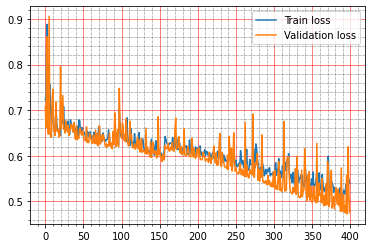

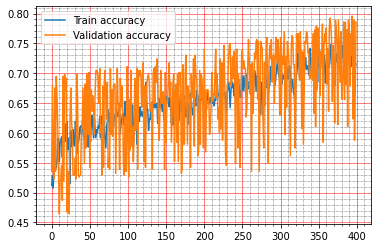

In [60]:
fig, ax = plt.subplots()
history_df = pd.DataFrame(history_res50.history)
history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax)
# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)
# Turn on the minor TICKS, which are required for the minor GRID
ax.minorticks_on()
# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='red')
# Customize the minor grid
ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.legend(["Train loss", "Validation loss"])
print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))

fig1, ax1 = plt.subplots()
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(ax=ax1)
ax1.set_axisbelow(True)
ax1.minorticks_on()
ax1.grid(which='major', linestyle='-', linewidth='0.5', color='red')
ax1.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax1.legend(["Train accuracy", "Validation accuracy"])
print(("Maximum Validation Accuracy: {:0.4f}").format(history_df['val_binary_accuracy'].max()))